<a href="https://colab.research.google.com/github/gustavoramos82/Reconhecimento-de-fake-news/blob/main/Detectando_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Fake News

Neste projeto, será feito um projeto de nlp, a partir de um dataset obtido no kaggle (que pode ser obtido [aqui](https://www.kaggle.com/datasets/ronikdedhia/fake-news)) em que será montado algoritmos de machine learning para prever se o texto é fake ou não. Será feita visualizações, no que for possivel, tratamento dos dados, modelagem e comparação das métricas.

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 72 kB/s 


In [87]:
# Importando as bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
fake = pd.read_csv('/content/drive/MyDrive/Datasets/fake_news.csv')
fake.drop('id',axis=1,inplace=True)
fake.head()

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### Dicionário dos dados

- **title**: O titulo da noticia.
- **author**: autor da noticia.
- **text**: texto da noticia, podendo estar incompleto.
- **label**: o target sendo 1 = não confiavel/ fake e 0 = confiavel/ não é fake

## Análise Exploratória

In [5]:
fake.shape

(20800, 4)

Este dataset tem em torno de de 20 mil linhas, temos um dataset bem grade para utilizar.

In [6]:
fake['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

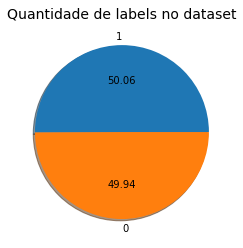

In [7]:
plt.title('Quantidade de labels no dataset',fontsize=14)
plt.pie(fake['label'].value_counts(),shadow=True,autopct='%1.2f',
        labels=fake['label'].value_counts().index);

Tem-se praticamente metade de cada classificação, mostrando que temos um dataset balanceado.

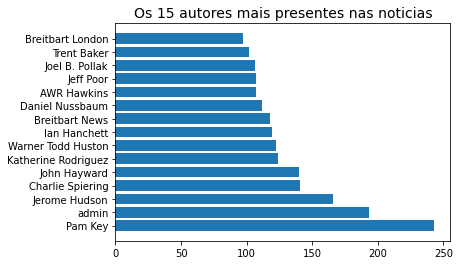

In [8]:
plt.title('Os 15 autores mais presentes nas noticias',fontsize=14)
plt.barh(fake['author'].value_counts()[0:15].index,fake['author'].value_counts()[0:15]);

## Pre Processamento

In [9]:
fake['title'] = fake['title'].str.lower()
fake['text'] = fake['text'].str.lower()

In [10]:
fake.isna().sum()

title      558
author    1957
text        39
label        0
dtype: int64

O autor será desconsiderado na aplicação do modelo quando ao resto será retirado as linhas com valores nulos.

In [11]:
fake.drop('author',axis=1,inplace=True)
fake.dropna(inplace=True)

In [12]:
fake.isna().sum()

title    0
text     0
label    0
dtype: int64

In [13]:
fake.duplicated().sum()

71

In [14]:
fake.drop_duplicates(inplace=True)

In [15]:
fake.duplicated().sum()

0

In [16]:
#removendo stopwords
stop = stopwords.words('english')
fake['title'] = fake['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
fake['text'] = fake['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [17]:
# Aplicando lemantização
def lema(coluna):
  lema = []
  wnl = WordNetLemmatizer()
  lista = list(coluna)
  for i in range(len(lista)):
    lista_le = nltk.word_tokenize(lista[i])
    junta = ' '.join([wnl.lemmatize(words) for words in lista_le])
    lema.append(junta)
  coluna = lema
  return coluna

In [18]:
fake['title'] = lema(fake['title'])
fake['text'] = lema(fake['text'])

In [19]:
# Aplicando tokenização
def toke(coluna):
  tokenizer = RegexpTokenizer(r'[A-z]\w*')
  token = []
  lista = np.asarray(coluna)
  for i in range(len(coluna)):
    tokens = tokenizer.tokenize(lista[i])
    token.append(tokens)
  coluna = token
  return coluna

In [20]:
fake['title'] = toke(fake['title'])
fake['text'] = toke(fake['text'])

In [21]:
fake.head()

,title,text,label
0,"[house, dem, aide, didn, t, even, see, comey, ...","[house, dem, aide, didn, t, even, see, comey, ...",1
1,"[flynn, hillary, clinton, big, woman, campus, ...","[ever, get, feeling, life, circle, roundabout,...",0
2,"[truth, might, get, fired]","[truth, might, get, fired, october, tension, i...",1
3,"[civilian, killed, single, u, airstrike, ident...","[video, civilian, killed, single, u, airstrike...",1
4,"[iranian, woman, jailed, fictional, unpublishe...","[print, iranian, woman, sentenced, six, year, ...",1


In [22]:
# Aplicando o conutvectorizer do sklearn para extração de caracteristicas
vectorizer = CountVectorizer(lowercase=False,ngram_range=(1,1))
x1 = vectorizer.fit_transform(fake['title'].astype(str))

In [23]:
x2 = vectorizer.fit_transform(fake['text'].astype(str))

## Modelagem

### No titulo

In [24]:
x1_treino, x1_teste, y1_treino, y1_teste = train_test_split(x1,fake.label,test_size=0.20,random_state=42)

In [25]:
lg = LogisticRegression()
lg.fit(x1_treino,y1_treino)
y_lg = lg.predict(x1_teste)

In [26]:
confusion_matrix(y1_teste,y_lg)

array([[1861,  193],
       [  43, 1930]])

In [27]:
print('ACC',accuracy_score(y1_teste,y_lg))
print('PRE',precision_score(y1_teste,y_lg))
print('REC',recall_score(y1_teste,y_lg))

ACC 0.9413955798361063
PRE 0.9090909090909091
REC 0.9782057780030411


In [28]:
per = Perceptron()
per.fit(x1_treino,y1_treino)
y_per = per.predict(x1_teste)

In [29]:
confusion_matrix(y1_teste,y_per)

array([[1899,  155],
       [ 127, 1846]])

In [30]:
print('ACC',accuracy_score(y1_teste,y_per))
print('PRE',precision_score(y1_teste,y_per))
print('REC',recall_score(y1_teste,y_per))

ACC 0.9299726843804321
PRE 0.9225387306346826
REC 0.9356310187531678


In [31]:
multi = MultinomialNB()
multi.fit(x1_treino,y1_treino)
y_mul = multi.predict(x1_teste)

In [32]:
confusion_matrix(y1_teste,y_mul)

array([[1946,  108],
       [ 286, 1687]])

In [33]:
print('ACC',accuracy_score(y1_teste,y_mul))
print('PRE',precision_score(y1_teste,y_mul))
print('REC',recall_score(y1_teste,y_mul))

ACC 0.902160417184008
PRE 0.9398328690807799
REC 0.8550430816016219


In [34]:
knn = KNeighborsClassifier()
knn.fit(x1_treino,y1_treino)
y_knn = knn.predict(x1_teste)

In [35]:
confusion_matrix(y1_teste,y_knn)

array([[1263,  791],
       [   5, 1968]])

In [36]:
print('ACC',accuracy_score(y1_teste,y_knn))
print('PRE',precision_score(y1_teste,y_knn))
print('REC',recall_score(y1_teste,y_knn))

ACC 0.8023342438539856
PRE 0.7133019209858644
REC 0.9974657881398885


In [37]:
tree = DecisionTreeClassifier()
tree.fit(x1_treino,y1_treino)
y_tree = tree.predict(x1_teste)

In [38]:
confusion_matrix(y1_teste,y_tree)

array([[1866,  188],
       [ 122, 1851]])

In [39]:
print('ACC',accuracy_score(y1_teste,y_tree))
print('PRE',precision_score(y1_teste,y_tree))
print('REC',recall_score(y1_teste,y_tree))

ACC 0.923019617581326
PRE 0.9077979401667484
REC 0.9381652306132793


In [40]:
rf = RandomForestClassifier()
rf.fit(x1_treino,y1_treino)
y_rf = rf.predict(x1_teste)

In [41]:
confusion_matrix(y1_teste,y_rf)

array([[1832,  222],
       [  36, 1937]])

In [42]:
print('ACC',accuracy_score(y1_teste,y_rf))
print('PRE',precision_score(y1_teste,y_rf))
print('REC',recall_score(y1_teste,y_rf))

ACC 0.9359324559225229
PRE 0.8971746178786475
REC 0.9817536746071972


In [43]:
ex = ExtraTreesClassifier()
ex.fit(x1_treino,y1_treino)
y_ex = ex.predict(x1_teste)

In [44]:
confusion_matrix(y1_teste,y_ex)

array([[1868,  186],
       [  49, 1924]])

In [45]:
print('ACC',accuracy_score(y1_teste,y_ex))
print('PRE',precision_score(y1_teste,y_ex))
print('REC',recall_score(y1_teste,y_ex))

ACC 0.9416439036503601
PRE 0.9118483412322275
REC 0.9751647237709072


In [46]:
grad = GradientBoostingClassifier()
grad.fit(x1_treino,y1_treino)
y_grad = grad.predict(x1_teste)

In [47]:
confusion_matrix(y1_teste,y_grad)

array([[1738,  316],
       [  13, 1960]])

In [48]:
print('ACC',accuracy_score(y1_teste,y_grad))
print('PRE',precision_score(y1_teste,y_grad))
print('REC',recall_score(y1_teste,y_grad))

ACC 0.9183014651105041
PRE 0.8611599297012302
REC 0.99341104916371


In [49]:
svm = SVC(kernel='linear')
svm.fit(x1_treino,y1_treino)
y_svm = svm.predict(x1_teste)

In [50]:
confusion_matrix(y1_teste,y_svm)

array([[1898,  156],
       [  98, 1875]])

In [51]:
print('ACC',accuracy_score(y1_teste,y_svm))
print('PRE',precision_score(y1_teste,y_svm))
print('REC',recall_score(y1_teste,y_svm))

ACC 0.9369257511795381
PRE 0.9231905465288035
REC 0.9503294475418145


In [52]:
mlpc1 = MLPClassifier()
mlpc1.fit(x1_treino,y1_treino)
y_mlpc1 = mlpc1.predict(x1_teste)

In [53]:
confusion_matrix(y1_teste,y_mlpc1)

array([[1890,  164],
       [ 112, 1861]])

In [54]:
print('ACC',accuracy_score(y1_teste,y_mlpc1))
print('PRE',precision_score(y1_teste,y_mlpc1))
print('REC',recall_score(y1_teste,y_mlpc1))

ACC 0.9314626272659549
PRE 0.9190123456790124
REC 0.9432336543335023


In [55]:
cat = CatBoostClassifier()
cat.fit(x1_treino,y1_treino)
y_cat = cat.predict(x1_teste)

Learning rate set to 0.033753
0:	learn: 0.6415715	total: 128ms	remaining: 2m 8s
1:	learn: 0.5965487	total: 194ms	remaining: 1m 36s
2:	learn: 0.5571425	total: 261ms	remaining: 1m 26s
3:	learn: 0.5225005	total: 318ms	remaining: 1m 19s
4:	learn: 0.4925245	total: 380ms	remaining: 1m 15s
5:	learn: 0.4663425	total: 438ms	remaining: 1m 12s
6:	learn: 0.4435289	total: 496ms	remaining: 1m 10s
7:	learn: 0.4236015	total: 554ms	remaining: 1m 8s
8:	learn: 0.4060717	total: 617ms	remaining: 1m 7s
9:	learn: 0.3902140	total: 674ms	remaining: 1m 6s
10:	learn: 0.3752389	total: 741ms	remaining: 1m 6s
11:	learn: 0.3635206	total: 803ms	remaining: 1m 6s
12:	learn: 0.3530298	total: 866ms	remaining: 1m 5s
13:	learn: 0.3437006	total: 923ms	remaining: 1m 5s
14:	learn: 0.3354383	total: 983ms	remaining: 1m 4s
15:	learn: 0.3294392	total: 1.04s	remaining: 1m 4s
16:	learn: 0.3224227	total: 1.1s	remaining: 1m 3s
17:	learn: 0.3163294	total: 1.16s	remaining: 1m 3s
18:	learn: 0.3106925	total: 1.22s	remaining: 1m 3s
19:	le

In [56]:
confusion_matrix(y1_teste,y_cat)

array([[1786,  268],
       [  25, 1948]])

In [57]:
print('ACC',accuracy_score(y1_teste,y_cat))
print('PRE',precision_score(y1_teste,y_cat))
print('REC',recall_score(y1_teste,y_cat))

ACC 0.9272411224236404
PRE 0.8790613718411552
REC 0.9873289406994424


In [88]:
rid = RidgeClassifier()
rid.fit(x1_treino,y1_treino)
y_rid= rid.predict(x1_teste)

In [89]:
confusion_matrix(y1_teste,y_rid)

array([[1838,  216],
       [  58, 1915]])

In [90]:
print('ACC',accuracy_score(y1_teste,y_rid))
print('PRE',precision_score(y1_teste,y_rid))
print('REC',recall_score(y1_teste,y_rid))

ACC 0.9319592748944624
PRE 0.8986391365556077
REC 0.9706031424227065


podemos ver que os melhores modelos, comparando as métricas, foram a regressão logistica, o extratree classifier e o svm co kernel linear.

In [58]:
bag = BaggingClassifier(base_estimator=SVC(kernel='linear'),n_estimators=15)
bag.fit(x1_treino,y1_treino)
y_bag = bag.predict(x1_teste)

In [59]:
confusion_matrix(y1_teste,y_bag)

array([[1887,  167],
       [  68, 1905]])

In [60]:
print('ACC',accuracy_score(y1_teste,y_bag))
print('PRE',precision_score(y1_teste,y_bag))
print('REC',recall_score(y1_teste,y_bag))

ACC 0.9416439036503601
PRE 0.9194015444015444
REC 0.9655347187024835


Agora que obtivemos as metrica, escolheu-se a regressão logistica para melhorar o hiperparametro porque foi que obtiveram um dos melhores resultados.

In [84]:
parametros = {'penalty':['l1','l2'],'dual':[True,False],'C':np.arange(0.1,1,0.1),
              'max_iter':[100,110,120,130]}

In [85]:
grid = GridSearchCV(LogisticRegression(),param_grid=parametros).fit(x1_treino,y1_treino)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
540 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Sol

In [86]:
grid.best_params_

{'C': 0.9, 'dual': False, 'max_iter': 100, 'penalty': 'l2'}

In [81]:
lgg = LogisticRegression(C=0.9,dual=False)
lgg.fit(x1_treino,y1_treino)
y_lgg = lgg.predict(x1_teste)

In [82]:
confusion_matrix(y1_teste,y_lgg)

array([[1858,  196],
       [  44, 1929]])

In [83]:
print('ACC',accuracy_score(y1_teste,y_lgg))
print('PRE',precision_score(y1_teste,y_lgg))
print('REC',recall_score(y1_teste,y_lgg))

ACC 0.9404022845790911
PRE 0.9077647058823529
REC 0.9776989356310187


# Texto

In [61]:
x2_treino, x2_teste, y2_treino, y2_teste = train_test_split(x2,fake.label,test_size=0.20,random_state=42)

In [62]:
lg2 = LogisticRegression()
lg2.fit(x2_treino,y2_treino)
y_lg2 = lg2.predict(x2_teste)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [63]:
confusion_matrix(y2_teste,y_lg2)

array([[1947,  107],
       [ 105, 1868]])

In [64]:
print('ACC',accuracy_score(y1_teste,y_lg2))
print('PRE',precision_score(y1_teste,y_lg2))
print('REC',recall_score(y1_teste,y_lg2))

ACC 0.9473553513781972
PRE 0.9458227848101266
REC 0.9467815509376584


In [65]:
ex2 = ExtraTreesClassifier()
ex2.fit(x2_treino,y2_treino)
y_ex2 = ex2.predict(x2_teste)

In [66]:
confusion_matrix(y2_teste,y_ex2)

array([[1965,   89],
       [ 360, 1613]])

In [67]:
print('ACC',accuracy_score(y1_teste,y_ex2))
print('PRE',precision_score(y1_teste,y_ex2))
print('REC',recall_score(y1_teste,y_ex2))

ACC 0.8885026074000497
PRE 0.9477085781433607
REC 0.8175367460719716


In [68]:
svm2 = SVC(kernel='linear')
svm2.fit(x2_treino,y2_treino)
y_svm2 = svm2.predict(x2_teste)

In [69]:
confusion_matrix(y2_teste,y_svm2)

array([[1930,  124],
       [ 134, 1839]])

In [70]:
print('ACC',accuracy_score(y1_teste,y_svm2))
print('PRE',precision_score(y1_teste,y_svm2))
print('REC',recall_score(y1_teste,y_svm2))

ACC 0.9359324559225229
PRE 0.9368313805399898
REC 0.9320831221490117


In [71]:
per2 = Perceptron()
per2.fit(x2_treino,y2_treino)
y_per2 = per2.predict(x2_teste)

In [72]:
confusion_matrix(y2_teste,y_per2)

array([[1978,   76],
       [ 116, 1857]])

In [73]:
print('ACC',accuracy_score(y1_teste,y_per2))
print('PRE',precision_score(y1_teste,y_per2))
print('REC',recall_score(y1_teste,y_per2))

ACC 0.9523218276632729
PRE 0.9606828763579928
REC 0.941206284845413


In [74]:
mlpc = MLPClassifier()
mlpc.fit(x2_treino,y2_treino)
y_mlpc = mlpc.predict(x2_teste)


In [75]:
confusion_matrix(y2_teste,y_mlpc)

array([[1960,   94],
       [  81, 1892]])

In [76]:
print('ACC',accuracy_score(y1_teste,y_mlpc))
print('PRE',precision_score(y1_teste,y_mlpc))
print('REC',recall_score(y1_teste,y_mlpc))

ACC 0.9565433325055873
PRE 0.9526686807653575
REC 0.9589457678661936
